# Testes com RNN
O objetivo desses testes é apenas se familiarizar com o Keras e experimentar com RNNs.

In [123]:
import matplotlib.pyplot as plt
import pandas
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math
import keras
import numpy as np

from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 15, 6

## Minimum Daily Temperatures in Melbourne, Australia

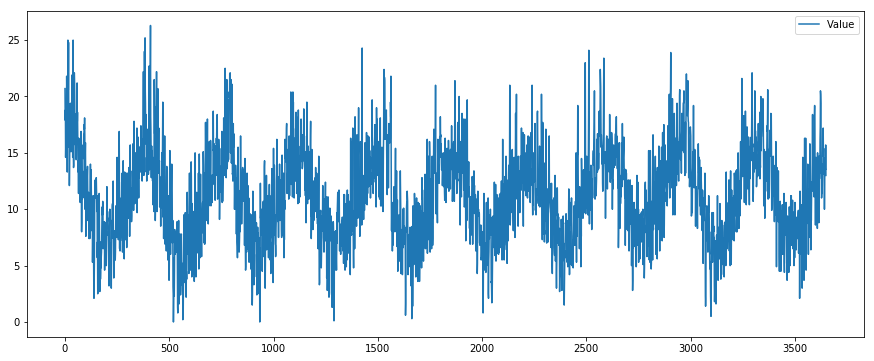

In [41]:
# carregar o dataset
series = pandas.read_csv('temperatures.csv', header=0)
series.plot()
plt.show()

X = series.values[:, 1]

## Baseline

Deve-se estabelecer um parâmetro inicial de erro, para que possamos compará-lo com a performance do modelo final.

Para isso, usaremos um simples walk forward

Root mean squared error:  2.7503656875995803


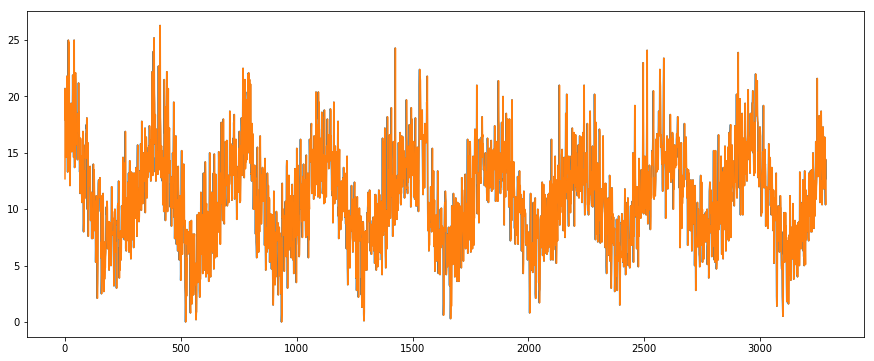

In [42]:
train, test = X[0:-365], X[:-365]
predictions = [train[-1]]
for val in test[0:-1]:
    predictions.append(val)
    
# root mean squared error
rmse = math.sqrt(mean_squared_error(test, predictions))
print("Root mean squared error: ", rmse)

plt.plot(test)
plt.plot(predictions)
plt.show()

## Tratamento de dados

Normalização é importante para modelos LSTM

In [153]:
def timeseries_to_supervised(data, lag=1):
    df = pandas.DataFrame(data)
    shifted = df.shift()
    shifted.fillna(0, inplace=True)
    df = pandas.concat([shifted, df], axis=1)
    df.columns = ['X', 'y']
    return df

# train e test devem ter a mesma escala
def scale(data, scaler=MinMaxScaler(feature_range=(-1, 1))):
    data = data.reshape(-1, 1)
    return scaler, scaler.fit_transform(data)

## RNN

In [136]:
def fit_model(training_data, batch_size, epochs, neurons):
    X, y = training_data['X'].values, training_data['y'].values
    X = X.reshape(X.shape[0], 1, 1) # samples, timesteps, features
    model = keras.models.Sequential([
        keras.layers.LSTM(neurons, 
                          batch_input_shape=(batch_size, X.shape[1], X.shape[2]), # ???
                          stateful=True),
        keras.layers.Dense(1)
    ])
    model.compile(loss='mean_squared_error', 
                  optimizer='adam') # adam optimizer é rápido
    
    for epoch in range(epochs):
        model.fit(X, y, batch_size=batch_size, shuffle=False, verbose=0)
        model.reset_states()
        if (epoch+1) % 50 == 0:
            print('epoch %d of %d done' % (epoch+1, epochs))
    return model

def predict(model, batch_size, data):
    length = len(data) if isinstance(data, (np.ndarray, list)) else 1
    data = data.reshape(1, 1, length)
    return model.predict(data, batch_size)[0, 0]

## Execução

In [97]:
BATCH_SIZE = 1
EPOCHS = 100
NEURONS = 4

In [100]:
scaler, X_scaled = scale(X)
train, test = X_scaled[0:-365], X_scaled[:-365]

train_supervised = timeseries_to_supervised(train)
test_supervised = timeseries_to_supervised(test)

print('starting training')
model = fit_model(train_supervised, BATCH_SIZE, EPOCHS, NEURONS)
print('done training')

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


starting training
epoch 50 of 100 done
epoch 100 of 100 done
done training


starting predictions
Test error:  2.551846664397445
done


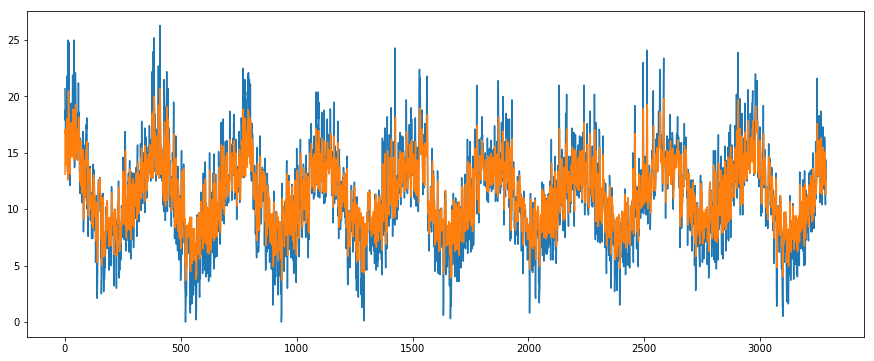

In [157]:
# build up state for validation
model.reset_states()
model.predict(train.reshape(train.shape[0], 1, 1), batch_size=BATCH_SIZE)

print('starting predictions')
predictions = []
for i in range(len(test)):
    X, y = test_supervised.loc[i]['X'], invert_scale(scaler, test_supervised.loc[i]['y'])
    yhat = predict(model, BATCH_SIZE, X)
    yhat = scaler.inverse_transform(yhat)[0, 0]
    predictions.append(yhat)
#     print("%d: Predicted=%.1f | Expected=%.1f" % (i, yhat, y))

test_unscaled = scaler.inverse_transform(test_supervised['y'].values.reshape(1, -1))[0]
rmse = math.sqrt(mean_squared_error(test_unscaled, predictions))
print("Test error: ", rmse)
print('done')

plt.plot(test_unscaled)
plt.plot(predictions)
plt.show()